In [2]:
import preconditioners
import numpy as np
import pandas as pd

In [3]:
from preconditioners.datasets import generate_c, generate_centered_linear_gaussian_data, generate_true_parameter, generate_W_star

def kernel_variance_interpolator(features : np.ndarray, P : np.ndarray, F : np.ndarray, sigma2 : np.float64) -> np.float64:
    ''' Given Nxp feature matrix {features}, pxp symmetric preconditioner P and pxp true covariance matrix F, and the signal to noise ratio, this function returns the variance component of the risk 
    of the interpolator which is the limit of PGD which uses preconditioner P.'''
    assert features.shape[1] == P.shape[0] == P.shape[1] == F.shape[0] == F.shape[1]
    assert np.linalg.norm(P - P.T) < 1e-7, 'P must be symmetric.'

    empirical_NTK = features.dot(P).dot(features.T)
    empirical_NTK_inv = np.linalg.inv(empirical_NTK)
    auxi_matrix = features.dot(P).dot(F).dot(P).dot(features.T)

    return sigma2 * np.trace(empirical_NTK_inv.dot(auxi_matrix).dot(empirical_NTK_inv))

In [4]:
# write some tests for the above function

def kernel_variance_test(N, d, sigma2):

    N = 50
    d = 100
    r2 = 1
    sigma2 = 2

    c = generate_c(ro=0.9, regime='autoregressive', d=d)
    inv_c = np.linalg.inv(c)
    X = np.random.multivariate_normal(mean=np.zeros(d), cov=c, size=N)

    ngd_interpol_var = sigma2 * np.trace(np.linalg.inv(X.dot(inv_c).dot(X.T)))
    pgd_interpol_var = kernel_variance_interpolator(X, P = inv_c, F = c, sigma2 = sigma2)
    assert abs(ngd_interpol_var - pgd_interpol_var) < 1e-15, \
        f'variance of ngd interpolator is {ngd_interpol_var} but variance of pgd interpolator is {pgd_interpol_var}, their difference is {ngd_interpol_var - pgd_interpol_var}'

def large_limit_test_min_norm(N, d, sigma2):
    assert d > N, 'd must be larger than N.'
    assert N >= 200, 'd and N must be large for this to hold.'

    gamma = d/N
    r2 = 1

    c = np.eye(d)
    X = np.random.multivariate_normal(mean=np.zeros(d), cov=c, size=N)
    P = np.eye(d)
    
    analytic_var_limit = sigma2 / (gamma - 1)
    experimental_var = kernel_variance_interpolator(features=X, P=P, F=c, sigma2=sigma2)
    assert abs(analytic_var_limit - experimental_var) < 0.05, \
        f'observed variance was {experimental_var} but variance of limit is {analytic_var_limit}, their difference is {experimental_var - analytic_var_limit}'

def large_limit_test_orlai(N, d, sigma2):
    '''Same as function large_limit_test_min_norm but with autoregressive covariance c and preconditionre P=c^{-1}.'''
    assert d > N, 'd must be larger than N.'
    assert N >= 200, 'd and N must be large for this to hold.'

    gamma = d/N
    r2 = 1

    c = generate_c(ro=0.9, regime='autoregressive', d=d)
    X = np.random.multivariate_normal(mean=np.zeros(d), cov=c, size=N)
    P = np.linalg.inv(c)
    
    analytic_var_limit = sigma2 / (gamma - 1)
    experimental_var = kernel_variance_interpolator(features=X, P=P, F=c, sigma2=sigma2)
    assert abs(analytic_var_limit - experimental_var) < 0.05, \
        f'observed variance was {experimental_var} but variance of limit is {analytic_var_limit}, their difference is {experimental_var - analytic_var_limit}'

In [5]:
# and test it

kernel_variance_test(N=50, d=100, sigma2=2)
large_limit_test_min_norm(N=200, d=400, sigma2=2)
large_limit_test_orlai(N=200, d=400, sigma2=2)

### Now compute the variance for different values of d, lambda for damped NGD, in the case of a linear feature map

In [6]:
# Are there some properties that I want the feature map to have?
# 1. The eigenvalues of the Fisher should grow with d like in the NTK case
# 2. (probably relax this) The NTK kernel is assumed to have a lower bounded smallest eigenvalue in the infinite-width limit
# perhaps nothing else is needed?
from sklearn.kernel_approximation import RBFSampler

def feature_map(X, dimension):#, n):
    # approximates the infinite-dimensional RBF feature map
    rbf_sampler = RBFSampler(gamma=1, random_state=1, n_components=dimension)
    X_features = rbf_sampler.fit_transform(X)
    return X_features
    #return n*n**(0.425)*X_features

In [7]:
(0.425 + 0.006125 - 0.425)/2 + 0.425

0.4280625

In [31]:
import matplotlib.pyplot as plt
import numpy as np
from preconditioners.datasets import generate_true_parameter, CenteredLinearGaussianDataset, generate_true_parameter, generate_c
from torch.utils.data import random_split

N = 20
N_extra = 30000
d = 30
sigma2 = 2
n_ns = 10
n_lams = 6
variances_damped = np.zeros((n_ns,n_lams))
variances_ngd = np.zeros((n_ns,n_lams))
variances_diff = np.zeros((n_ns,n_lams))

largest_eigval_F_prelim = np.zeros((n_ns,n_lams))
smallest_eigval_F_div_n = np.zeros((n_ns,n_lams))
largest_eigval_F_div_n = np.zeros((n_ns,n_lams))


ns = [int(x) for x in np.linspace(int(np.sqrt(2*N)),int(2*N),n_ns)]
lams = np.logspace(1, -2, num=n_lams, endpoint=True, base=10.0)
dampings = []

k = 0
for i in range(n_ns):
    for j in range(n_lams):
        k = k+1
        print(f'iteration {k} of {n_ns*n_lams}')
        n = ns[i]
        p = n ** 2
        lam = lams[j]
        damping = lam * n # TODO: check if multiplying by n is correct
        dampings.append(damping)

        w_star = generate_true_parameter(d, r2=1, m=np.eye(d))
        c = generate_c(ro=0.9, regime='autoregressive', d=d)
        dataset = CenteredLinearGaussianDataset(w_star, c, n=N + N_extra, d=d, sigma2=sigma2)
        train_dataset, extra_dataset = random_split(dataset, [N, N_extra])

        X, X_extra, X_all = train_dataset[:][0].numpy(), extra_dataset[:][0].numpy(), dataset[:][0].numpy()
        features_prelim, features_extra_prelim, features_all_prelim = feature_map(X, dimension=p), feature_map(X_extra, dimension=p), feature_map(X_all, dimension=p)

        assert features_prelim.shape == (N, p)
        assert features_extra_prelim.shape == (N_extra, p)
        assert features_all_prelim.shape == (N + N_extra, p)

        # TODO: Need to check how are the smallest and largest eigenvalues of the Fisher distributed        
        # TODO: make sure the eigenvalues of the Fisher grow with n as they should

        # TODO: check this again
        F_extra_prelim = features_extra_prelim.T @ features_extra_prelim / N_extra
        largest_eigval_F_prelim[i, j] = np.linalg.eigvalsh(F_extra_prelim)[-1]

        mu = np.sqrt(n / largest_eigval_F_prelim[i, j])
        features, features_extra, features_all = [mu * x for x in [features_prelim, features_extra_prelim, features_all_prelim]]
        F_extra = mu**2 * F_extra_prelim

        smallest_eigval_F_div_n[i, j] = np.linalg.eigvalsh(F_extra)[0]/n
        largest_eigval_F_div_n[i, j] = np.linalg.eigvalsh(F_extra)[-1]/n
        P_ngd = np.linalg.inv(F_extra)
        P_damped = np.linalg.inv(F_extra + damping * np.eye(p))

        variances_damped[i, j] = kernel_variance_interpolator(features=features, P=P_damped, F=F_extra, sigma2=sigma2) 
        variances_ngd[i, j] = kernel_variance_interpolator(features=features, P=P_ngd, F=F_extra, sigma2=sigma2)
        variances_diff = variances_damped - variances_ngd



iteration 1 of 60


/Users/eduardoravkin/Desktop/ml_research/phd/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')


iteration 2 of 60
iteration 3 of 60
iteration 4 of 60


/Users/eduardoravkin/Desktop/ml_research/phd/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')
/Users/eduardoravkin/Desktop/ml_research/phd/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')
/Users/eduardoravkin/Desktop/ml_research/phd/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')


iteration 5 of 60
iteration 6 of 60
iteration 7 of 60


/Users/eduardoravkin/Desktop/ml_research/phd/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')
/Users/eduardoravkin/Desktop/ml_research/phd/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')
/Users/eduardoravkin/Desktop/ml_research/phd/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')


iteration 8 of 60
iteration 9 of 60


/Users/eduardoravkin/Desktop/ml_research/phd/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')
/Users/eduardoravkin/Desktop/ml_research/phd/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')


iteration 10 of 60
iteration 11 of 60


/Users/eduardoravkin/Desktop/ml_research/phd/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')
/Users/eduardoravkin/Desktop/ml_research/phd/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')


iteration 12 of 60
iteration 13 of 60


/Users/eduardoravkin/Desktop/ml_research/phd/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')
/Users/eduardoravkin/Desktop/ml_research/phd/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')


iteration 14 of 60
iteration 15 of 60


/Users/eduardoravkin/Desktop/ml_research/phd/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')
/Users/eduardoravkin/Desktop/ml_research/phd/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')


iteration 16 of 60
iteration 17 of 60


/Users/eduardoravkin/Desktop/ml_research/phd/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')
/Users/eduardoravkin/Desktop/ml_research/phd/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')


iteration 18 of 60
iteration 19 of 60


/Users/eduardoravkin/Desktop/ml_research/phd/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')
/Users/eduardoravkin/Desktop/ml_research/phd/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')


iteration 20 of 60


/Users/eduardoravkin/Desktop/ml_research/phd/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')


iteration 21 of 60


/Users/eduardoravkin/Desktop/ml_research/phd/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')


iteration 22 of 60


/Users/eduardoravkin/Desktop/ml_research/phd/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')


iteration 23 of 60


/Users/eduardoravkin/Desktop/ml_research/phd/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')


iteration 24 of 60


/Users/eduardoravkin/Desktop/ml_research/phd/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')


iteration 25 of 60


/Users/eduardoravkin/Desktop/ml_research/phd/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')


iteration 26 of 60


/Users/eduardoravkin/Desktop/ml_research/phd/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')


iteration 27 of 60


/Users/eduardoravkin/Desktop/ml_research/phd/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')


iteration 28 of 60


/Users/eduardoravkin/Desktop/ml_research/phd/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')


iteration 29 of 60


/Users/eduardoravkin/Desktop/ml_research/phd/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')


iteration 30 of 60


/Users/eduardoravkin/Desktop/ml_research/phd/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')


iteration 31 of 60


/Users/eduardoravkin/Desktop/ml_research/phd/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')


iteration 32 of 60


/Users/eduardoravkin/Desktop/ml_research/phd/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')


iteration 33 of 60


/Users/eduardoravkin/Desktop/ml_research/phd/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')


iteration 34 of 60


/Users/eduardoravkin/Desktop/ml_research/phd/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')


iteration 35 of 60


/Users/eduardoravkin/Desktop/ml_research/phd/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')


iteration 36 of 60


/Users/eduardoravkin/Desktop/ml_research/phd/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')


iteration 37 of 60


/Users/eduardoravkin/Desktop/ml_research/phd/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')


iteration 38 of 60


/Users/eduardoravkin/Desktop/ml_research/phd/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')


iteration 39 of 60


/Users/eduardoravkin/Desktop/ml_research/phd/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')


iteration 40 of 60


/Users/eduardoravkin/Desktop/ml_research/phd/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')


iteration 41 of 60


/Users/eduardoravkin/Desktop/ml_research/phd/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')


iteration 42 of 60


/Users/eduardoravkin/Desktop/ml_research/phd/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')


iteration 43 of 60


/Users/eduardoravkin/Desktop/ml_research/phd/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')


iteration 44 of 60


/Users/eduardoravkin/Desktop/ml_research/phd/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')


iteration 45 of 60


/Users/eduardoravkin/Desktop/ml_research/phd/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')


iteration 46 of 60


/Users/eduardoravkin/Desktop/ml_research/phd/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')


iteration 47 of 60


/Users/eduardoravkin/Desktop/ml_research/phd/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')


iteration 48 of 60


/Users/eduardoravkin/Desktop/ml_research/phd/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')


iteration 49 of 60


/Users/eduardoravkin/Desktop/ml_research/phd/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')


iteration 50 of 60


/Users/eduardoravkin/Desktop/ml_research/phd/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')


iteration 51 of 60


/Users/eduardoravkin/Desktop/ml_research/phd/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')


iteration 52 of 60


/Users/eduardoravkin/Desktop/ml_research/phd/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')


iteration 53 of 60


/Users/eduardoravkin/Desktop/ml_research/phd/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')


iteration 54 of 60


/Users/eduardoravkin/Desktop/ml_research/phd/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')


iteration 55 of 60


/Users/eduardoravkin/Desktop/ml_research/phd/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')


iteration 56 of 60


/Users/eduardoravkin/Desktop/ml_research/phd/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')


iteration 57 of 60


/Users/eduardoravkin/Desktop/ml_research/phd/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')


iteration 58 of 60


/Users/eduardoravkin/Desktop/ml_research/phd/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')


iteration 59 of 60


/Users/eduardoravkin/Desktop/ml_research/phd/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')


iteration 60 of 60


/Users/eduardoravkin/Desktop/ml_research/phd/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')


In [32]:
features_all.shape

(30020, 1600)

In [33]:
lams

array([10.        ,  2.51188643,  0.63095734,  0.15848932,  0.03981072,
        0.01      ])

In [34]:
print(variances_diff[0,:])
print(variances_diff[-1,:])


[1.05725498e-03 5.63683307e-04 2.06027571e-04 2.90256840e-05
 2.84977406e-06 2.30411832e-07]
[1.17147535e-03 8.25408297e-04 3.28742178e-04 5.66349710e-05
 4.98933628e-06 3.49955808e-07]


In [35]:
print(variances_diff[:,0])
print(variances_diff[:,-1])

[0.00105725 0.00102039 0.00114625 0.00110371 0.00115129 0.00115439
 0.0011256  0.00117712 0.0011634  0.00117148]
[2.30411832e-07 1.48471179e-07 1.74556392e-07 1.96022400e-07
 2.13098910e-07 2.27673735e-07 2.51441727e-07 2.76069387e-07
 3.10230515e-07 3.49955808e-07]


<AxesSubplot: >

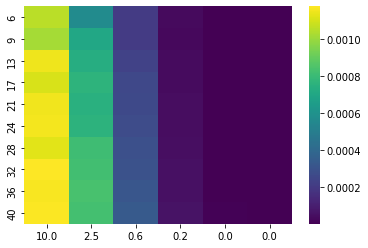

In [36]:
import seaborn as sns
sns.heatmap(variances_diff, cmap='viridis', xticklabels=[round(x, 1) for x in lams], yticklabels=ns)

<AxesSubplot: >

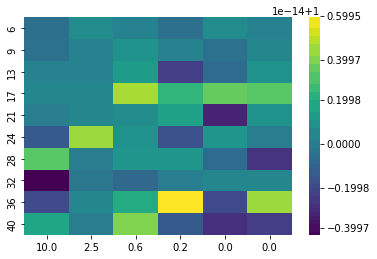

In [37]:
sns.heatmap(largest_eigval_F_div_n, cmap='viridis', xticklabels=[round(x, 1) for x in lams], yticklabels=ns)

<AxesSubplot: >

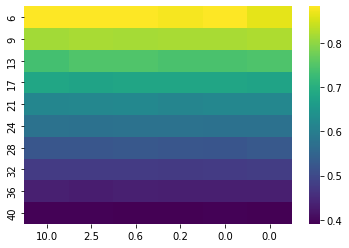

In [38]:
sns.heatmap(smallest_eigval_F_div_n, cmap='viridis', xticklabels=[round(x, 1) for x in lams], yticklabels=ns)

## Same thing as above but for larger n (n goes up to 5N)

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from preconditioners.datasets import generate_true_parameter, CenteredLinearGaussianDataset, generate_true_parameter, generate_c
from torch.utils.data import random_split

N = 20
N_extra = 30000
d = 30
sigma2 = 2
n_ns = 5
n_lams = 3
variances_damped = np.zeros((n_ns,n_lams))
variances_ngd = np.zeros((n_ns,n_lams))
variances_diff = np.zeros((n_ns,n_lams))

largest_eigval_F_prelim = np.zeros((n_ns,n_lams))
smallest_eigval_F_div_n = np.zeros((n_ns,n_lams))
largest_eigval_F_div_n = np.zeros((n_ns,n_lams))


ns = [int(x) for x in np.linspace(int(np.sqrt(2*N)),int(5*N),n_ns)]
lams = np.logspace(1, -2, num=n_lams, endpoint=True, base=10.0)
dampings = []

k = 0
for i in range(n_ns):
    for j in range(n_lams):
        k = k+1
        print(f'iteration {k} of {n_ns*n_lams}')
        n = ns[i]
        p = n ** 2
        lam = lams[j]
        damping = lam * n # TODO: check if multiplying by n is correct
        dampings.append(damping)

        w_star = generate_true_parameter(d, r2=1, m=np.eye(d))
        c = generate_c(ro=0.9, regime='autoregressive', d=d)
        dataset = CenteredLinearGaussianDataset(w_star, c, n=N + N_extra, d=d, sigma2=sigma2)
        train_dataset, extra_dataset = random_split(dataset, [N, N_extra])

        X, X_extra, X_all = train_dataset[:][0].numpy(), extra_dataset[:][0].numpy(), dataset[:][0].numpy()
        features_prelim, features_extra_prelim, features_all_prelim = feature_map(X, dimension=p), feature_map(X_extra, dimension=p), feature_map(X_all, dimension=p)

        assert features_prelim.shape == (N, p)
        assert features_extra_prelim.shape == (N_extra, p)
        assert features_all_prelim.shape == (N + N_extra, p)

        # TODO: Need to check how are the smallest and largest eigenvalues of the Fisher distributed        
        # TODO: make sure the eigenvalues of the Fisher grow with n as they should

        # TODO: check this again
        F_extra_prelim = features_extra_prelim.T @ features_extra_prelim / N_extra
        largest_eigval_F_prelim[i, j] = np.linalg.eigvalsh(F_extra_prelim)[-1]

        mu = np.sqrt(n / largest_eigval_F_prelim[i, j])
        features, features_extra, features_all = [mu * x for x in [features_prelim, features_extra_prelim, features_all_prelim]]
        F_extra = mu**2 * F_extra_prelim

        smallest_eigval_F_div_n[i, j] = np.linalg.eigvalsh(F_extra)[0]/n
        largest_eigval_F_div_n[i, j] = np.linalg.eigvalsh(F_extra)[-1]/n
        P_ngd = np.linalg.inv(F_extra)
        P_damped = np.linalg.inv(F_extra + damping * np.eye(p))

        variances_damped[i, j] = kernel_variance_interpolator(features=features, P=P_damped, F=F_extra, sigma2=sigma2) 
        variances_ngd[i, j] = kernel_variance_interpolator(features=features, P=P_ngd, F=F_extra, sigma2=sigma2)
        variances_diff = variances_damped - variances_ngd



iteration 1 of 15


/Users/eduardoravkin/Desktop/ml_research/phd/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')


iteration 2 of 15
iteration 3 of 15
iteration 4 of 15


/Users/eduardoravkin/Desktop/ml_research/phd/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')
/Users/eduardoravkin/Desktop/ml_research/phd/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')
/Users/eduardoravkin/Desktop/ml_research/phd/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')


iteration 5 of 15


/Users/eduardoravkin/Desktop/ml_research/phd/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')


iteration 6 of 15


/Users/eduardoravkin/Desktop/ml_research/phd/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')


iteration 7 of 15


/Users/eduardoravkin/Desktop/ml_research/phd/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')


iteration 8 of 15


/Users/eduardoravkin/Desktop/ml_research/phd/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')


iteration 9 of 15


/Users/eduardoravkin/Desktop/ml_research/phd/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')


iteration 10 of 15


/Users/eduardoravkin/Desktop/ml_research/phd/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')


iteration 11 of 15


/Users/eduardoravkin/Desktop/ml_research/phd/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')


iteration 12 of 15


/Users/eduardoravkin/Desktop/ml_research/phd/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')


iteration 13 of 15


/Users/eduardoravkin/Desktop/ml_research/phd/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')


iteration 14 of 15


/Users/eduardoravkin/Desktop/ml_research/phd/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')


KeyboardInterrupt: 

In [25]:
features_all.shape

In [26]:
lams

array([10.        ,  0.31622777,  0.01      ])

In [27]:
print(variances_diff[0,:])
print(variances_diff[-1,:])


[1.36010542e-03 7.25446147e-05 1.71546454e-07]
[0.00123872 0.         0.        ]


In [28]:
print(variances_diff[:,0])
print(variances_diff[:,-1])

[0.00136011 0.00117694 0.00118154 0.00122509 0.00123872]
[1.71546454e-07 2.64309787e-07 4.93064044e-07 9.98466127e-07
 0.00000000e+00]


<AxesSubplot: >

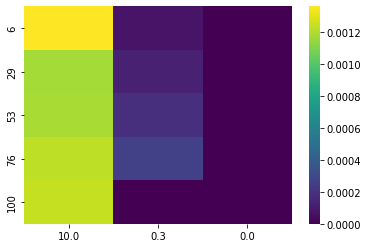

In [29]:
import seaborn as sns
sns.heatmap(variances_diff, cmap='viridis', xticklabels=[round(x, 1) for x in lams], yticklabels=ns)

<AxesSubplot: >

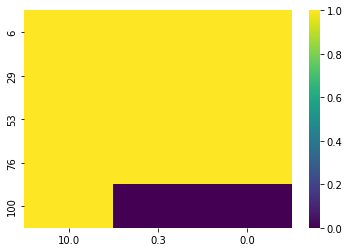

In [30]:
sns.heatmap(largest_eigval_F_div_n, cmap='viridis', xticklabels=[round(x, 1) for x in lams], yticklabels=ns)

<AxesSubplot: >

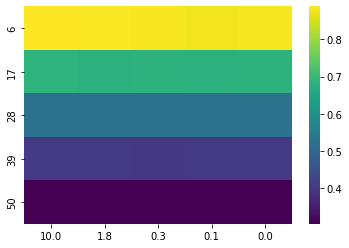

In [ ]:
sns.heatmap(smallest_eigval_F_div_n, cmap='viridis', xticklabels=[round(x, 1) for x in lams], yticklabels=ns)